# DLC and Loads Comparisons between AWC Cases

In [1]:
#!/usr/bin/env python3
import os,sys
import numpy as np 
#import ruamel.yaml as yaml
import yaml
import argparse
import pathlib
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import fatpack

### Helper Functions

In [2]:
def approximate_period(AWC,RotSpeed,time,windSpeed,diam,st,dt,t1=120,time_interval=600):
    """
    t1 - transient time to ignore
    """
    omega_e = 2*np.pi * float(st) * float(windSpeed) / float(diam)

    t2 = t1 + time_interval #length of simulation 
    t2_history = []
    t2_temp = t2
    for i in range(25): # iterate 10 times to converge
        mask = (time <= t2_temp) & (time  >= t1)
        RotSpeed_Window = RotSpeed[mask]
        meanRPM       = np.mean(RotSpeed_Window)
        Omega = meanRPM*2*np.pi/60

        if 'baseline' in AWC:
            return t2_temp

        elif 'dic' in AWC:
            period = (omega_e / (2*np.pi))**(-1)

        elif 'helix' in AWC: 
            period = ( (Omega + omega_e) / (2*np.pi))**(-1)

        elif 'sideside' in AWC:
            period = (2*omega_e / (2*np.pi))**(-1)
        else:
            return t2_temp

        t2_history = np.append(t2_history, t2_temp)
        t2_temp = t1 + np.floor(time_interval/ period) * period 
        t2_temp = np.floor(t2_temp/dt)*dt #approximate end time as multiple of dt 

    return t2_temp
    

### Set parameters and load data

In [3]:
turbines = ['T0','T1']
parentdir = '/projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/'

dirs = ['baseline_2T','ccwhelix_St03_A40_2T','dic_St03_A40_2T','sideside_St03_A40_2T','wakesteering_20deg_2T']
baseline_case = dirs[0]
legendtxt = ['Baseline','Helix','Pulse','Side-to-side','Wake steering']


#dirs = ['Baseline',]

# dirs = ['Baseline',\
#     'WM_Helix_A2_St_0p3',\
#     'WM_Helix_A4_St_0p3',\
#     'WM_Pulse_A2_St_0p3',\
#     'WM_Pulse_A4_St_0p3',\
#     'WM_SideToSide_A2_St_0p3',\
#     'WM_SideToSide_A4_St_0p3']


case_names = dirs

AWC_ST = 0.3
AWC_DIAM = 240.0         
windcases = [9.05,]
vars_and_labels = {'Time':('Time','s'),
            'RotSpeed':('Rotor Speed','rad / s'),
            'GenPwr':('Gen. Power','W'),
            'BldPitch1':('Blade Pitch','deg / s'),
            'RootMyb1':('Flapwise Moment','kN-m'), 
            'RootMxb1':('Edgewise Moment','kN-m'),
            'RotTorq':('Rotor Torque','kN-m'),
            'TwrBsMxt':('Tower base side-to-side moment','kN-m'),
            'TwrBsMyt':('Tower base Fore-aft Moment','kN-m'),
            'YawBrMyp':('Yaw Bearing Nodding Moment','kN-m'),
            'YawBrMzp':('Yaw Bearing Yawing Moment','kN-m'),
            'LSSTipMys':('LSS Nodding Moment','kN-m'),
            'LSSTipMzs':('LSS Yawing Moment','kN-m')
            }

del_vars = ['RootMyb1','RootMxb1','TwrBsMxt','TwrBsMyt','LSSTipMys','LSSTipMzs']
vars = list(vars_and_labels.keys())
print(vars)

['Time', 'RotSpeed', 'GenPwr', 'BldPitch1', 'RootMyb1', 'RootMxb1', 'RotTorq', 'TwrBsMxt', 'TwrBsMyt', 'YawBrMyp', 'YawBrMzp', 'LSSTipMys', 'LSSTipMzs']


Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/baseline_2T/OpenFAST/T0_Time.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/baseline_2T/OpenFAST/T0_RotSpeed.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/baseline_2T/OpenFAST/T0_GenPwr.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/baseline_2T/OpenFAST/T0_BldPitch1.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/baseline_2T/OpenFAST/T0_RootMyb1.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/baseline_2T/OpenFAST/T0_RootMxb1.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/baseline_2T/OpenFAST/T0_RotTorq.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/baseline_2T/OpenFAST/T0_TwrBsMxt.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI

Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/ccwhelix_St03_A40_2T/OpenFAST/T0_TwrBsMyt.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/ccwhelix_St03_A40_2T/OpenFAST/T0_YawBrMyp.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/ccwhelix_St03_A40_2T/OpenFAST/T0_YawBrMzp.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/ccwhelix_St03_A40_2T/OpenFAST/T0_LSSTipMys.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/ccwhelix_St03_A40_2T/OpenFAST/T0_LSSTipMzs.dat
            Time    Time.1  RotSpeed   GenPwr  BldPitch1  RootMyb1  RootMxb1  \
0          0.000     0.000     7.550  14980.0    0.00000    5125.0    -172.8   
1          0.005     0.005     7.540  14110.0    0.00000   10840.0    1325.0   
2          0.010     0.010     7.521  13850.0    0.08594    9558.0    5398.0   
3          0.015     0.015     7.491  14280.0    0.08

Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/dic_St03_A40_2T/OpenFAST/T1_BldPitch1.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/dic_St03_A40_2T/OpenFAST/T1_RootMyb1.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/dic_St03_A40_2T/OpenFAST/T1_RootMxb1.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/dic_St03_A40_2T/OpenFAST/T1_RotTorq.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/dic_St03_A40_2T/OpenFAST/T1_TwrBsMxt.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/dic_St03_A40_2T/OpenFAST/T1_TwrBsMyt.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/dic_St03_A40_2T/OpenFAST/T1_YawBrMyp.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/dic_St03_A40_2T/OpenFAST/T1_YawBrMzp.dat
Reading from:  /projects/ssc/jfrederi/am

Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/sideside_St03_A40_2T/OpenFAST/T1_YawBrMyp.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/sideside_St03_A40_2T/OpenFAST/T1_YawBrMzp.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/sideside_St03_A40_2T/OpenFAST/T1_LSSTipMys.dat
Reading from:  /projects/ssc/jfrederi/amr-wind-runs/snl_precursors/medWS_lowTI/sideside_St03_A40_2T/OpenFAST/T1_LSSTipMzs.dat
            Time    Time.1  RotSpeed   GenPwr  BldPitch1  RootMyb1  RootMxb1  \
0          0.000     0.000     7.550  14980.0     0.0000    5125.0    -172.8   
1          0.005     0.005     7.539  14110.0     0.0000   10640.0    1348.0   
2          0.010     0.010     7.520  13850.0     0.0000    9355.0    5395.0   
3          0.015     0.015     7.490  14280.0     0.0000   10370.0    8175.0   
4          0.020     0.020     7.456  14980.0     0.0000    9883.0    8591.0   
...          ...  

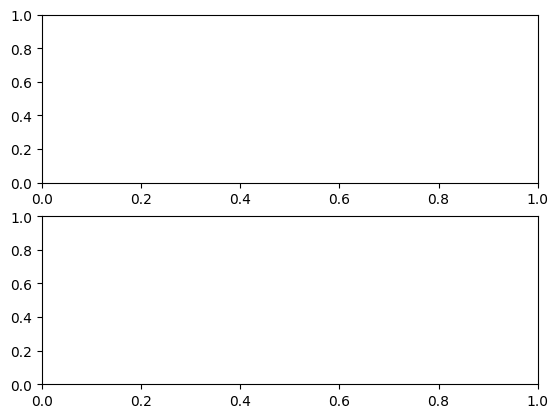

In [4]:
openfastData = {}
counter = 0
fig, ax = plt.subplots(len(turbines),1)
for caseiter, case in enumerate(case_names):
    openfastData[case] = {}
    for mps in windcases:
        openfastData[case][str(mps)] = {}
        dfs = []
        for turbiter, turbine in enumerate(turbines):
            for variter , var in enumerate(vars):
                file = parentdir + dirs[caseiter] + '/OpenFAST/' + turbine + '_' + var + '.dat'
                print('Reading from: ', file)
                #df = pd.read_csv(file,sep='\s+',skiprows=(1,))
                df = pd.read_csv(file,sep=' ',skiprows=(1,))
                #print(df)
                #duplicates = df[df.duplicated(subset='Time', keep=False)]
                df.drop_duplicates(subset='Time', inplace=True)
                if variter == 0:
                    dfs = df
                if variter > 0:
                    dfs = pd.merge(dfs, df, on="Time")
            print(dfs)
            openfastData[case][str(mps)][str(turbine)] = dfs
            #counter += 1
            print(openfastData[case][str(mps)].keys())
            # ax[turbiter].plot(openfastData[case][str(mps)][str(turbine)]['Time'],openfastData[case][str(mps)][str(turbine)]['GenPwr'])

### Compute Means and DELs

In [5]:
#compute means and DEL 
caseMeans = {}
caseDELs = {}

caseMeansRel = {}
caseDELsRel = {}
nr_list = []
total_time_list = []
nmean = np.inf

for caseiter, case in enumerate(case_names):
    caseMeans[case] = {}
    caseDELs[case] = {}
    caseMeansRel[case] = {}
    caseDELsRel[case] = {}
    for turbine in turbines:
        caseMeans[case][turbine] = {}
        caseDELs[case][turbine] = {}
        caseMeansRel[case][turbine] = {}
        caseDELsRel[case][turbine] = {}
        for cname in vars:
            caseMeans[case][turbine][cname] = []
            caseDELs[case][turbine][cname] = []
            caseMeansRel[case][turbine][cname] = []
            caseDELsRel[case][turbine][cname] = []
        nr_list.append([])
        total_time_list.append([])
        for mps in windcases:
            time  = openfastData[case][str(mps)][turbine]['Time']
            dt    = openfastData[case][str(mps)][turbine]['Time'][1] \
                        - openfastData[case][str(mps)][turbine]['Time'][0]
            tmax  = openfastData[case][str(mps)][turbine]['Time'].iloc[-1] \
                        - openfastData[case][str(mps)][turbine]['Time'][0]
            tinit = 500
            RotSpeed= openfastData[case][str(mps)][str(turbine)]['RotSpeed']
            tfinal = approximate_period(case,RotSpeed,time,mps,AWC_DIAM,AWC_ST,dt,t1=tinit,time_interval=tmax-tinit)
            total_time = tfinal - tinit
            nmean = int(total_time/dt)
            nel = len(openfastData[case][str(mps)][str(turbine)].Time) #number of timesteps
            print(case,nel,dt,total_time)
            #nr = np.array(range(nel-nmean,nel))             
            nel_init = int(tinit/dt)
            nr = np.array(range(nel_init,nel_init+nmean))
            total_time_list[caseiter].append(total_time)
            nr_list[caseiter].append(nr)
            print(case," ",tfinal," ",nr)


    for wc_counter, mps in enumerate(windcases):
        nr = nr_list[caseiter][wc_counter]
        total_time = np.min(total_time_list[:][wc_counter])
        for turbine in turbines:
            for counter, cname in enumerate(vars[2:]):
                cdata = openfastData[case][str(mps)][str(turbine)][cname]
                #append for each wind speed
                caseMeans[case][turbine][cname].append(np.mean(cdata[nr]))

                baseline_data = openfastData[baseline_case][str(mps)][turbine][cname]
                caseMeansRel[case][turbine][cname].append( np.mean(((cdata[nr]-baseline_data[nr])/baseline_data[nr])))
#                 caseMeansRel[case][turbine][cname].append(np.mean(baseline_data[nr]))
                try:
                    binNum = 100
                    m=10
                    t=total_time
                    ranges = fatpack.find_rainflow_ranges(cdata[nr])
                    Nrf, Srf = fatpack.find_range_count(ranges,binNum)
                    DELs = Srf**m * Nrf / t
                    DEL = DELs.sum() ** (1/m)
    
                    baseline_data = openfastData[baseline_case][str(mps)][turbine][cname]
                    binNum = 100
                    m=10
                    t=total_time
                    ranges = fatpack.find_rainflow_ranges(baseline_data[nr])
                    Nrf, Srf = fatpack.find_range_count(ranges,binNum)
                    DELs = Srf**m * Nrf / t
                    baseline_DEL = DELs.sum() ** (1/m)
                except:
                    DEL = 0.0
                    baseline_DEL = 1.0
                caseDELs[case][turbine][cname].append(np.mean(DEL))
                caseDELsRel[case][turbine][cname].append((DEL-baseline_DEL)/baseline_DEL)
                
ax[-1].legend(case_names)


baseline_2T 240001 0.005 700.0
baseline_2T   1200.0   [100000 100001 100002 ... 239997 239998 239999]
baseline_2T 240001 0.005 700.0
baseline_2T   1200.0   [100000 100001 100002 ... 239997 239998 239999]
ccwhelix_St03_A40_2T 240001 0.005 697.855
ccwhelix_St03_A40_2T   1197.855   [100000 100001 100002 ... 239568 239569 239570]
ccwhelix_St03_A40_2T 240001 0.005 692.31
ccwhelix_St03_A40_2T   1192.31   [100000 100001 100002 ... 238459 238460 238461]


/kfs3/scratch/lcheung/python/windconda1/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


dic_St03_A40_2T 240001 0.005 618.78
dic_St03_A40_2T   1118.78   [100000 100001 100002 ... 223752 223753 223754]
dic_St03_A40_2T 240001 0.005 618.78
dic_St03_A40_2T   1118.78   [100000 100001 100002 ... 223752 223753 223754]


/kfs3/scratch/lcheung/python/windconda1/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


sideside_St03_A40_2T 240001 0.005 662.98
sideside_St03_A40_2T   1162.98   [100000 100001 100002 ... 232593 232594 232595]
sideside_St03_A40_2T 240001 0.005 662.98
sideside_St03_A40_2T   1162.98   [100000 100001 100002 ... 232593 232594 232595]


/kfs3/scratch/lcheung/python/windconda1/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


wakesteering_20deg_2T 240001 0.005 700.0
wakesteering_20deg_2T   1200.0   [100000 100001 100002 ... 239997 239998 239999]
wakesteering_20deg_2T 240001 0.005 700.0
wakesteering_20deg_2T   1200.0   [100000 100001 100002 ... 239997 239998 239999]


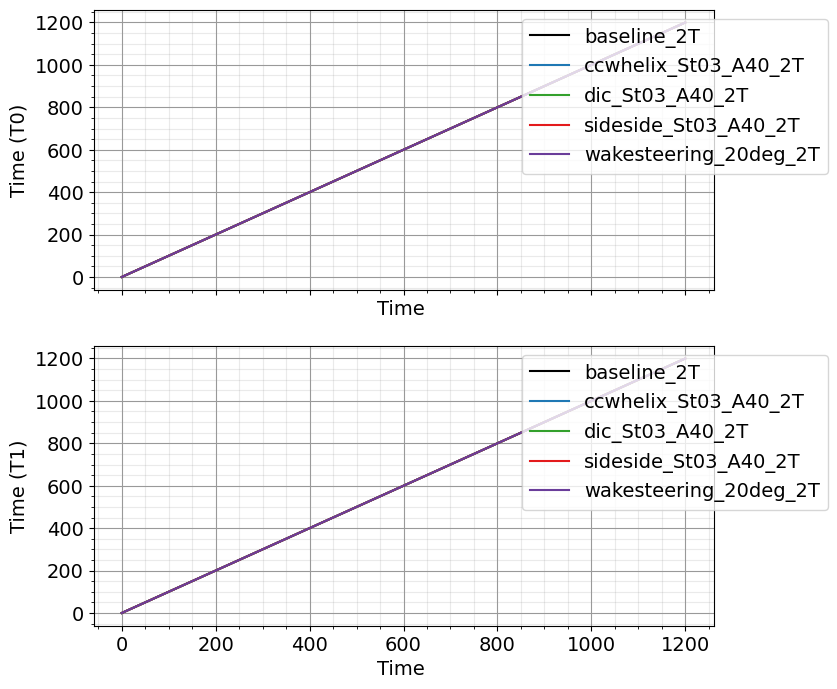

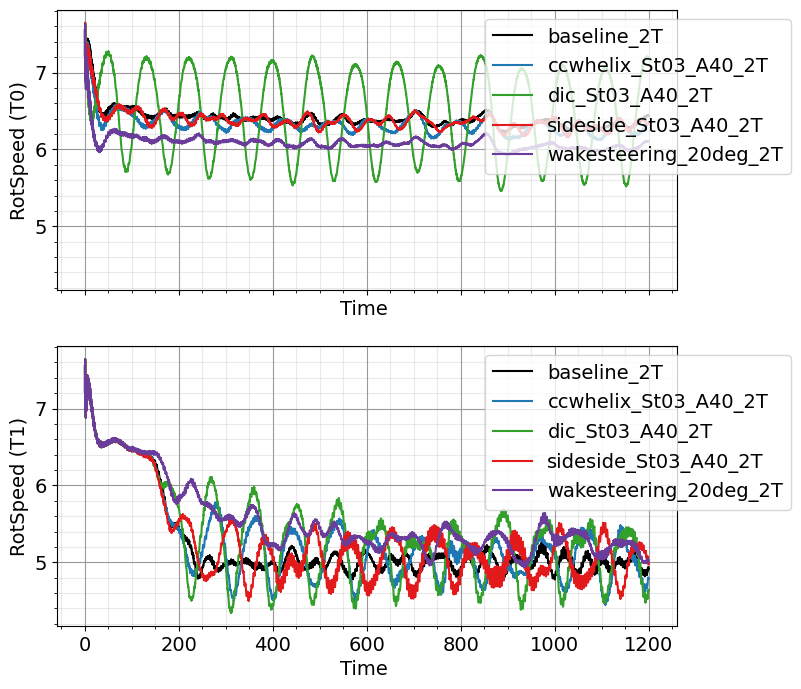

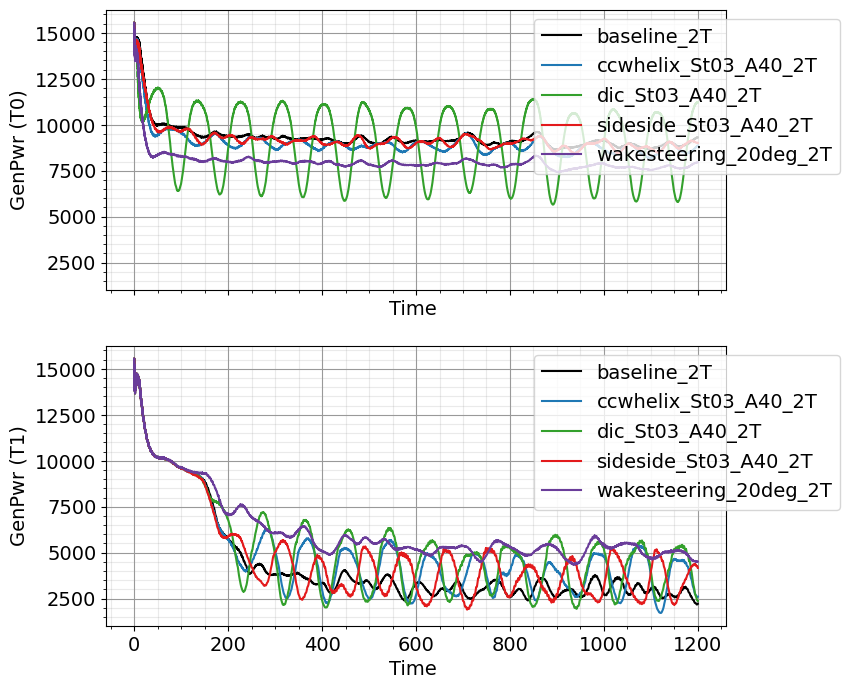

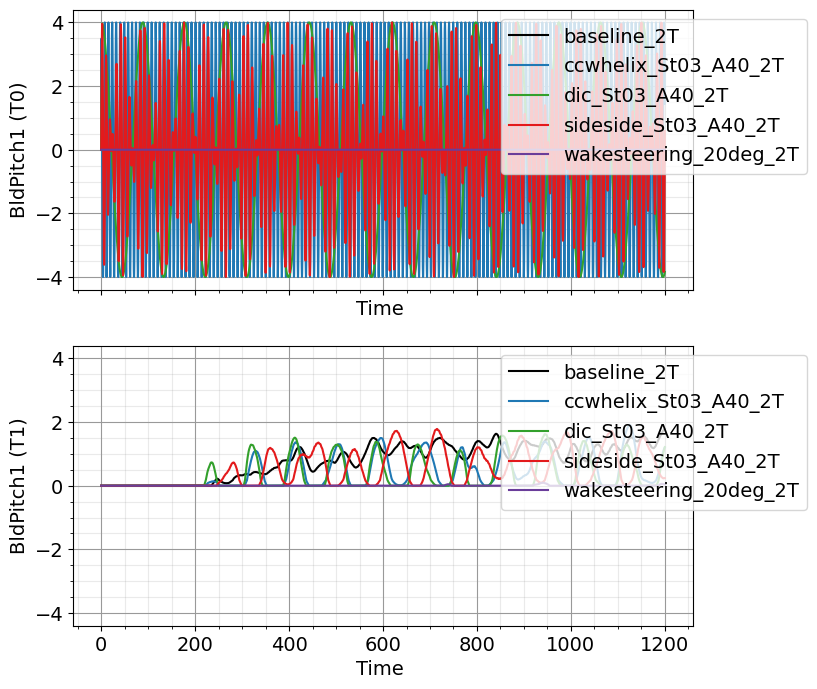

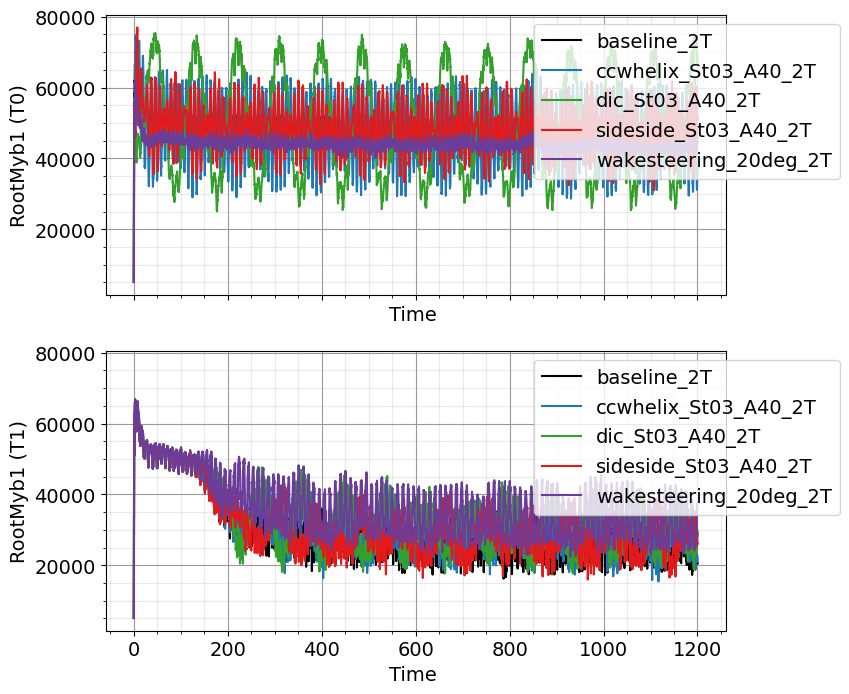

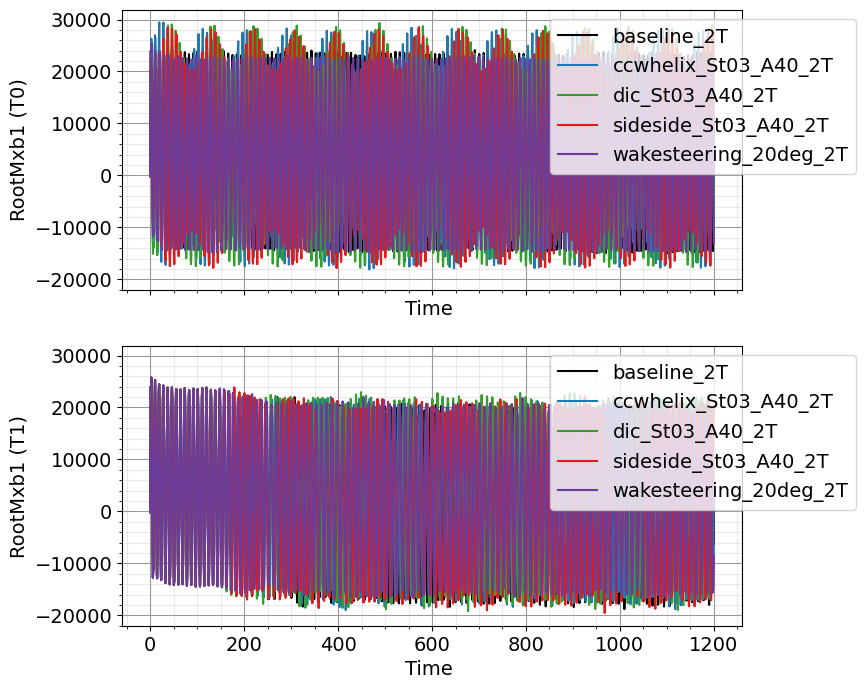

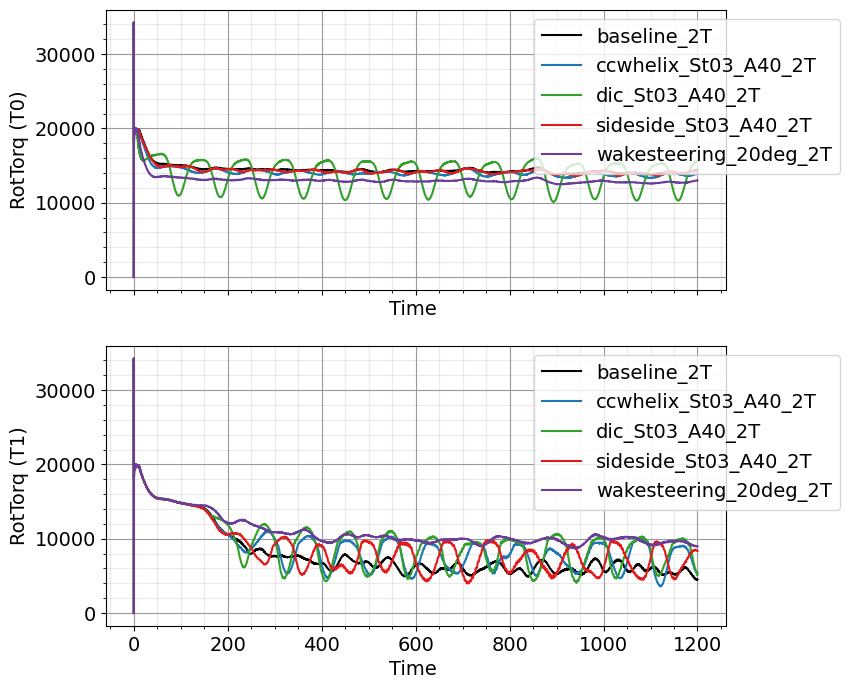

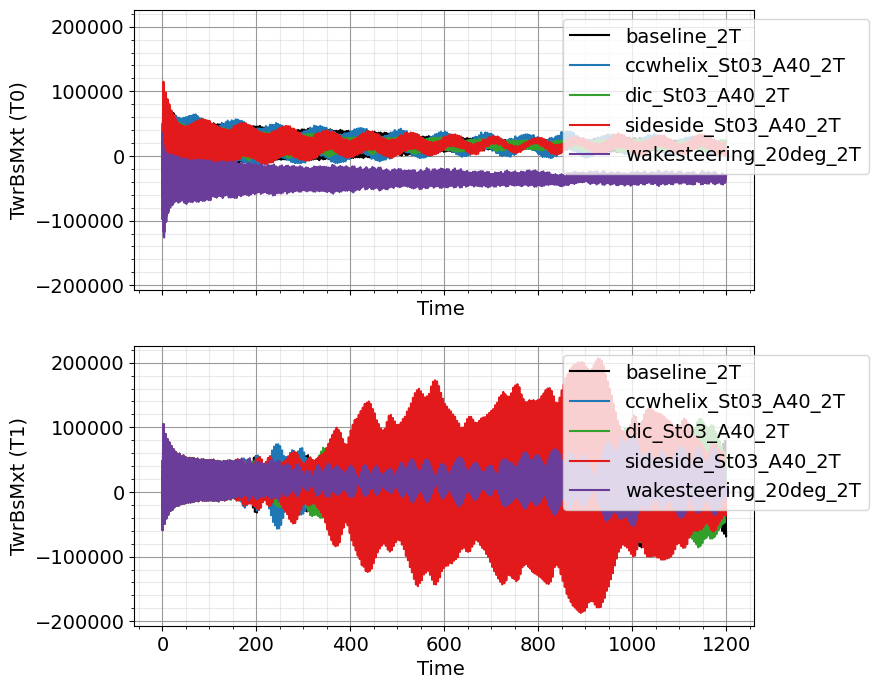

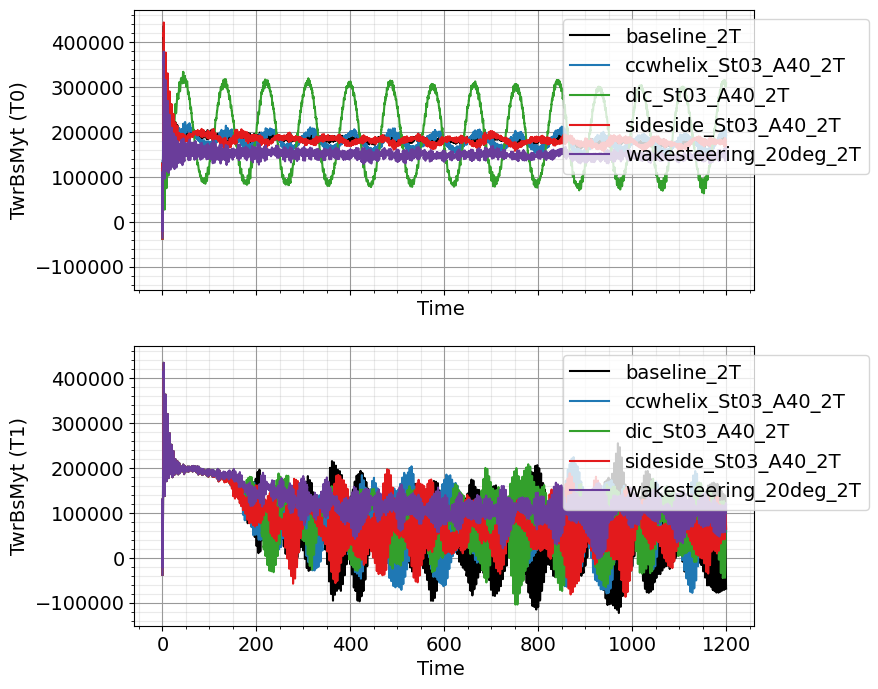

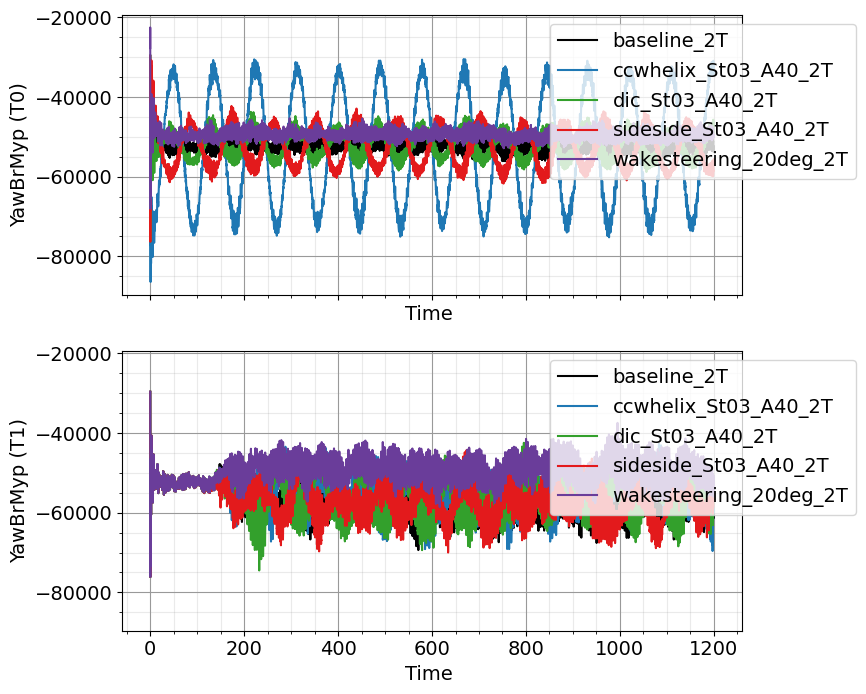

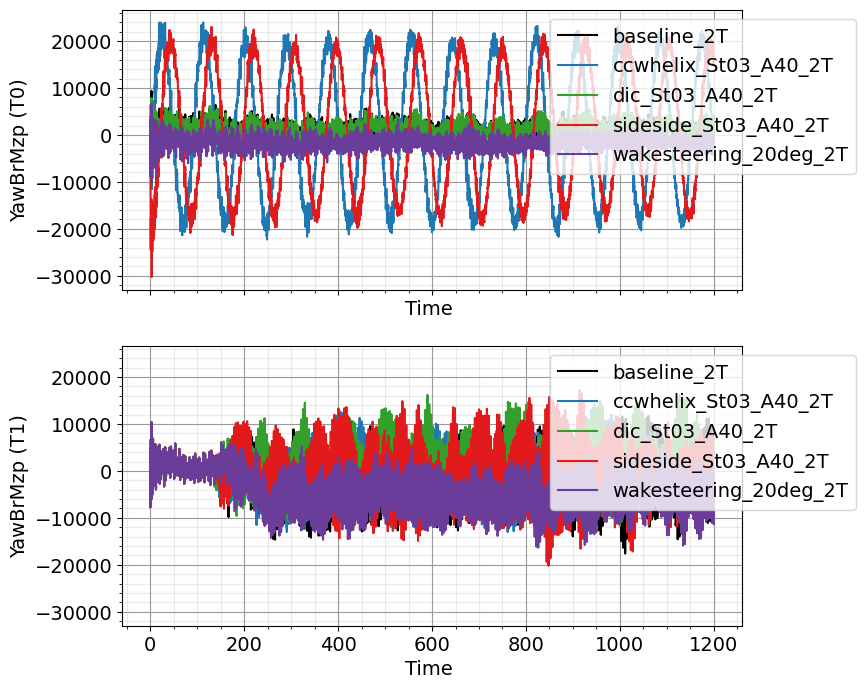

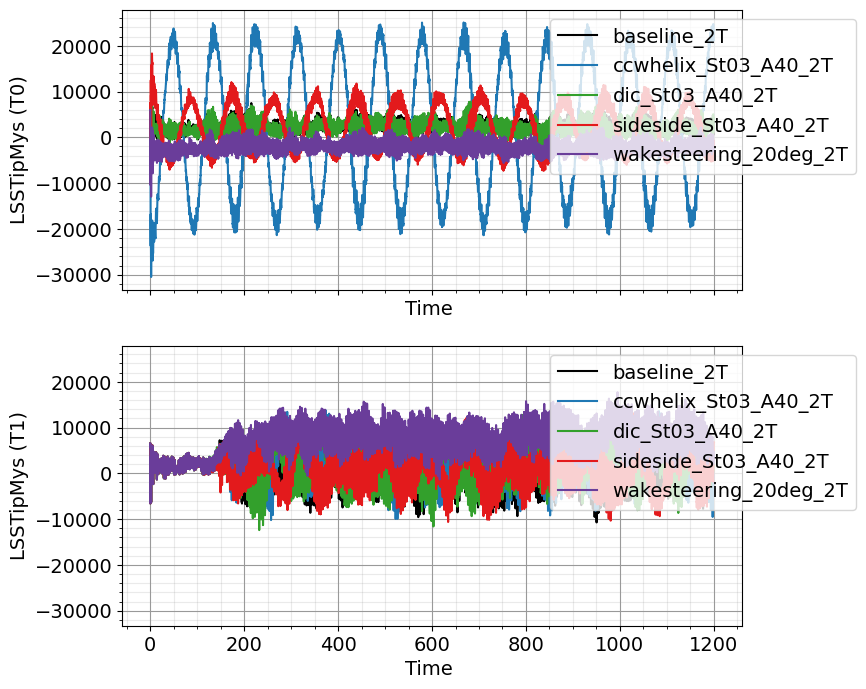

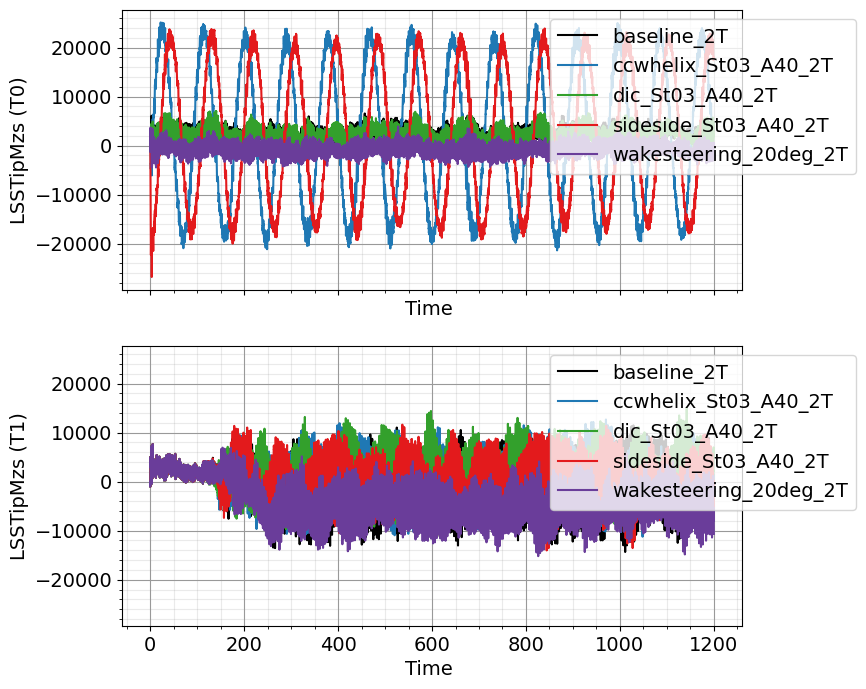

In [14]:
#plot mean data
#colors = ['k','tab:blue','tab:purple','tab:red']
colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
colors = ['k','#1f78b4','#33a02c','#e31a1c','#6a3d9a']
timeseries_vars = vars
for tvar in timeseries_vars:
    fig, ax1 = plt.subplots(len(turbines),1,figsize=(8,4*len(turbines)),sharex=True,sharey=True)
    for turbiter, turbine in enumerate(turbines):
        counter = 0
        for caseiter, case in enumerate(case_names):
            #if "WS" not in case:
            if 'baseline' in case:
                marker = '*'
            else:
                marker = '.'
            ax1[turbiter].plot(openfastData[case][str(mps)][turbine]['Time'],openfastData[case][str(mps)][turbine][tvar],label=case,c=colors[counter])
#             print(case,tvar,caseMeans[case][turbine][tvar])
            counter += 1

        fsize = 14
        #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
        ax1[turbiter].set_ylabel(tvar + " ("+ turbine +")",fontsize=fsize)
        ax1[turbiter].set_xlabel("Time ",fontsize=fsize)
        ax1[turbiter].grid(visible=True, which='major', color='#999999', linestyle='-')
        ax1[turbiter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax1[turbiter].minorticks_on()
        ax1[turbiter].tick_params(axis='x',labelsize=fsize)
        ax1[turbiter].tick_params(axis='y',labelsize=fsize)
        #ax1.ticklabel_format(style='sci',axis='x',scilimits=(0,0))

        ax1[turbiter].legend(loc='upper right',bbox_to_anchor=(1.2,1),fontsize=fsize)

        counter = 0
        for caseiter, case in enumerate(case_names):
            #if "WS" not in case:
            if 'Baseline' in case:
                marker = '*'
            else:
                marker = '.'
            #ax1.scatter(total_time_list[caseiter][0]+tinit-(1200-tinit),12000,marker='D',c=colors[counter])
            #ax1.axvline(x=total_time_list[caseiter][0]+tinit, linestyle='dashed', color=colors[counter])
            counter += 1
    #ax1.axvline(x=tinit, linestyle='dashed', color='k')

### Power T0 vs DEL T0

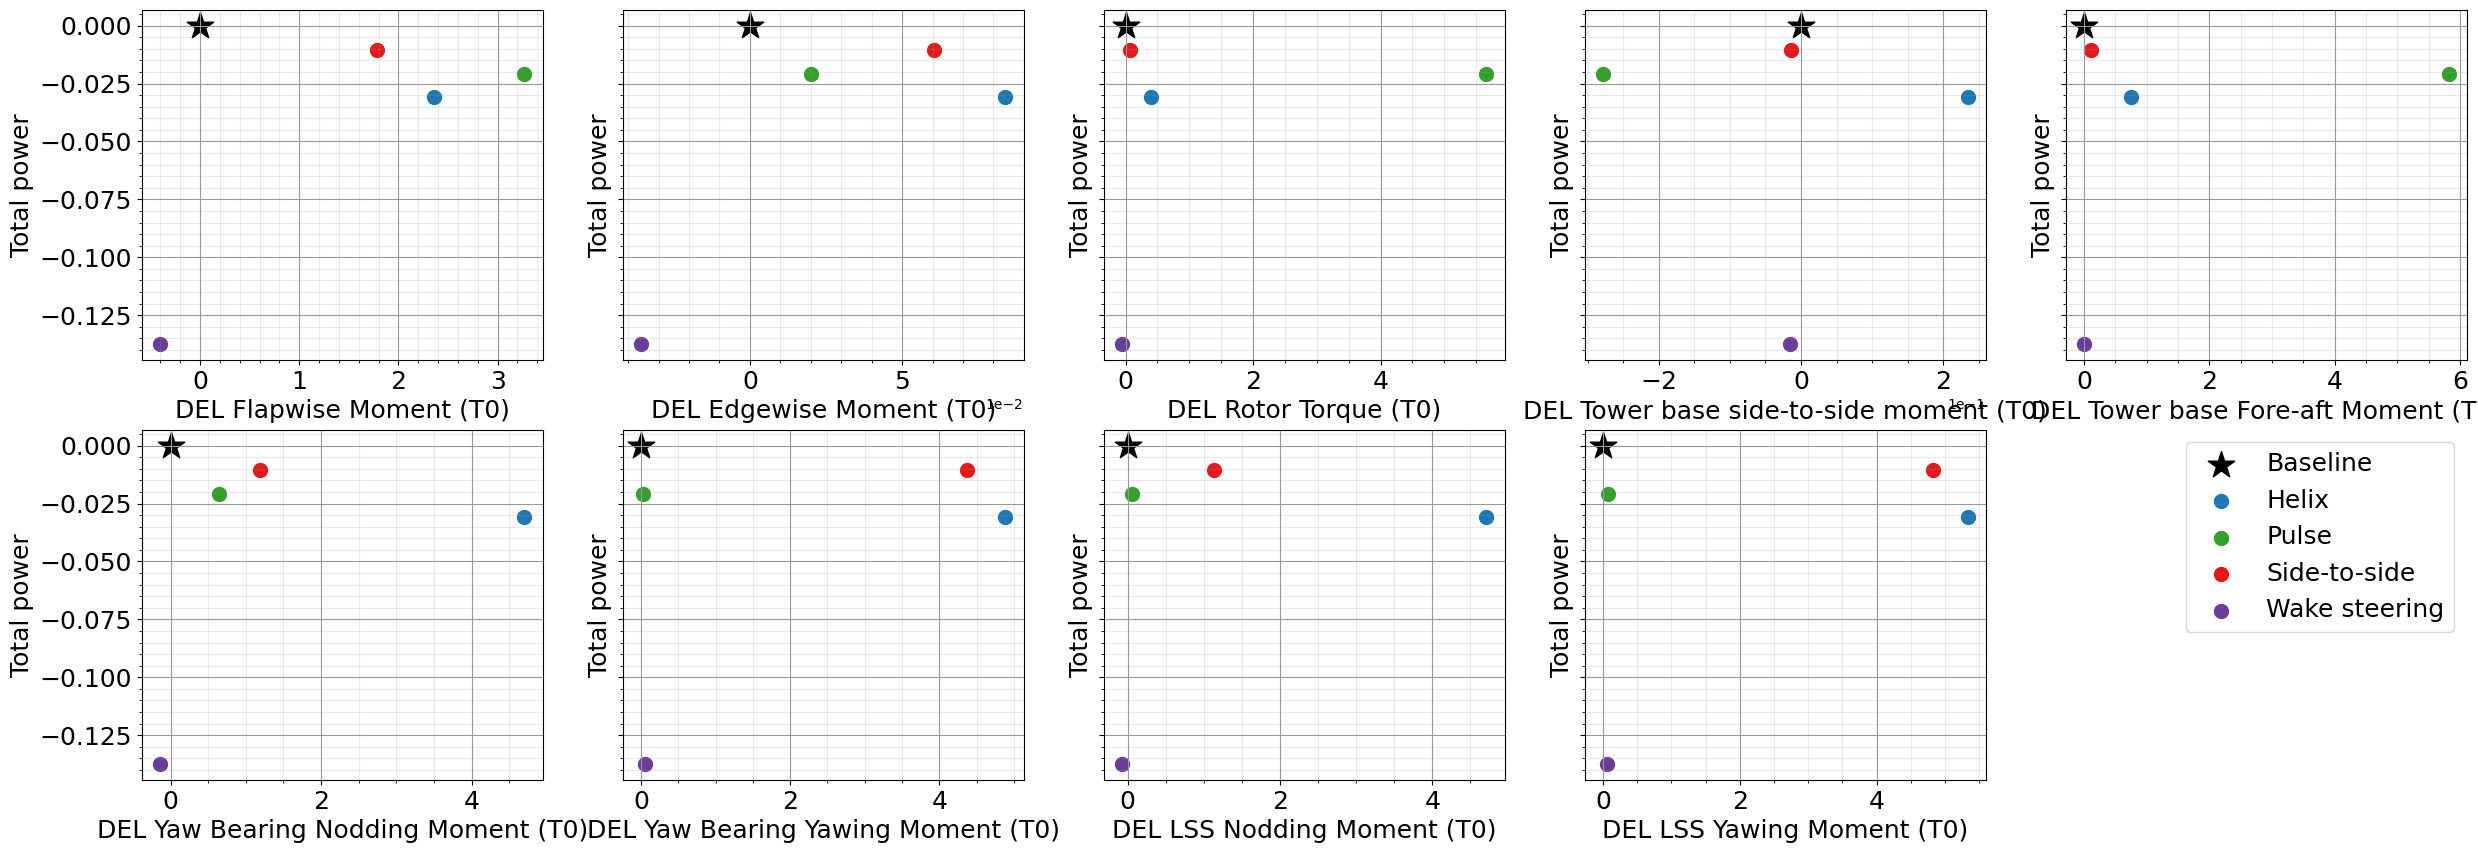

In [8]:
#plot mean data
#colors = ['k','tab:blue','tab:purple','tab:red']
colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
colors = ['k','#1f78b4','#33a02c','#e31a1c','#6a3d9a']
fig, ax1 = plt.subplots(2, 5,figsize=(30,10),sharex=False,sharey=True)
ax1=ax1.flatten()
ax_counter = 0
baseline_power = caseMeans[baseline_case]['T0']['GenPwr'][0]+caseMeans[baseline_case]['T0']['GenPwr'][0]
# for turbine in turbines[0]:
turbine = 'T0'
for quantity in vars[4:]: 
    counter = 0
    for caseiter, case in enumerate(case_names):
        #if "WS" not in case:
        if 'baseline' in case:
            marker = '*'
        else:
            marker = '.'
        total_power = (caseMeans[case]['T0']['GenPwr'][0]+caseMeans[case]['T0']['GenPwr'][0])/baseline_power
        baseDEL = caseDELs[baseline_case][turbine][quantity][0]
        ax1[ax_counter].scatter(caseDELs[case][turbine][quantity][0]/baseDEL-1,total_power-1,label=legendtxt[caseiter],c=colors[counter],marker=marker,s=400)
        counter += 1

    fsize = 18
    #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
    ax1[ax_counter].set_ylabel("Total power",fontsize=fsize)
    ax1[ax_counter].set_xlabel("DEL " + vars_and_labels[quantity][0] + " ("+turbine+")",fontsize=fsize)
    ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
    ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax1[ax_counter].minorticks_on()
    ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
    ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
    ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

    #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
    #fig.tight_layout()
    ax_counter += 1

ax1[-1].axis('off')
ax1[-2].legend(loc='upper right',bbox_to_anchor=(2.2,1),fontsize=fsize)

# fig.savefig('comp_init.png',dpi=240)

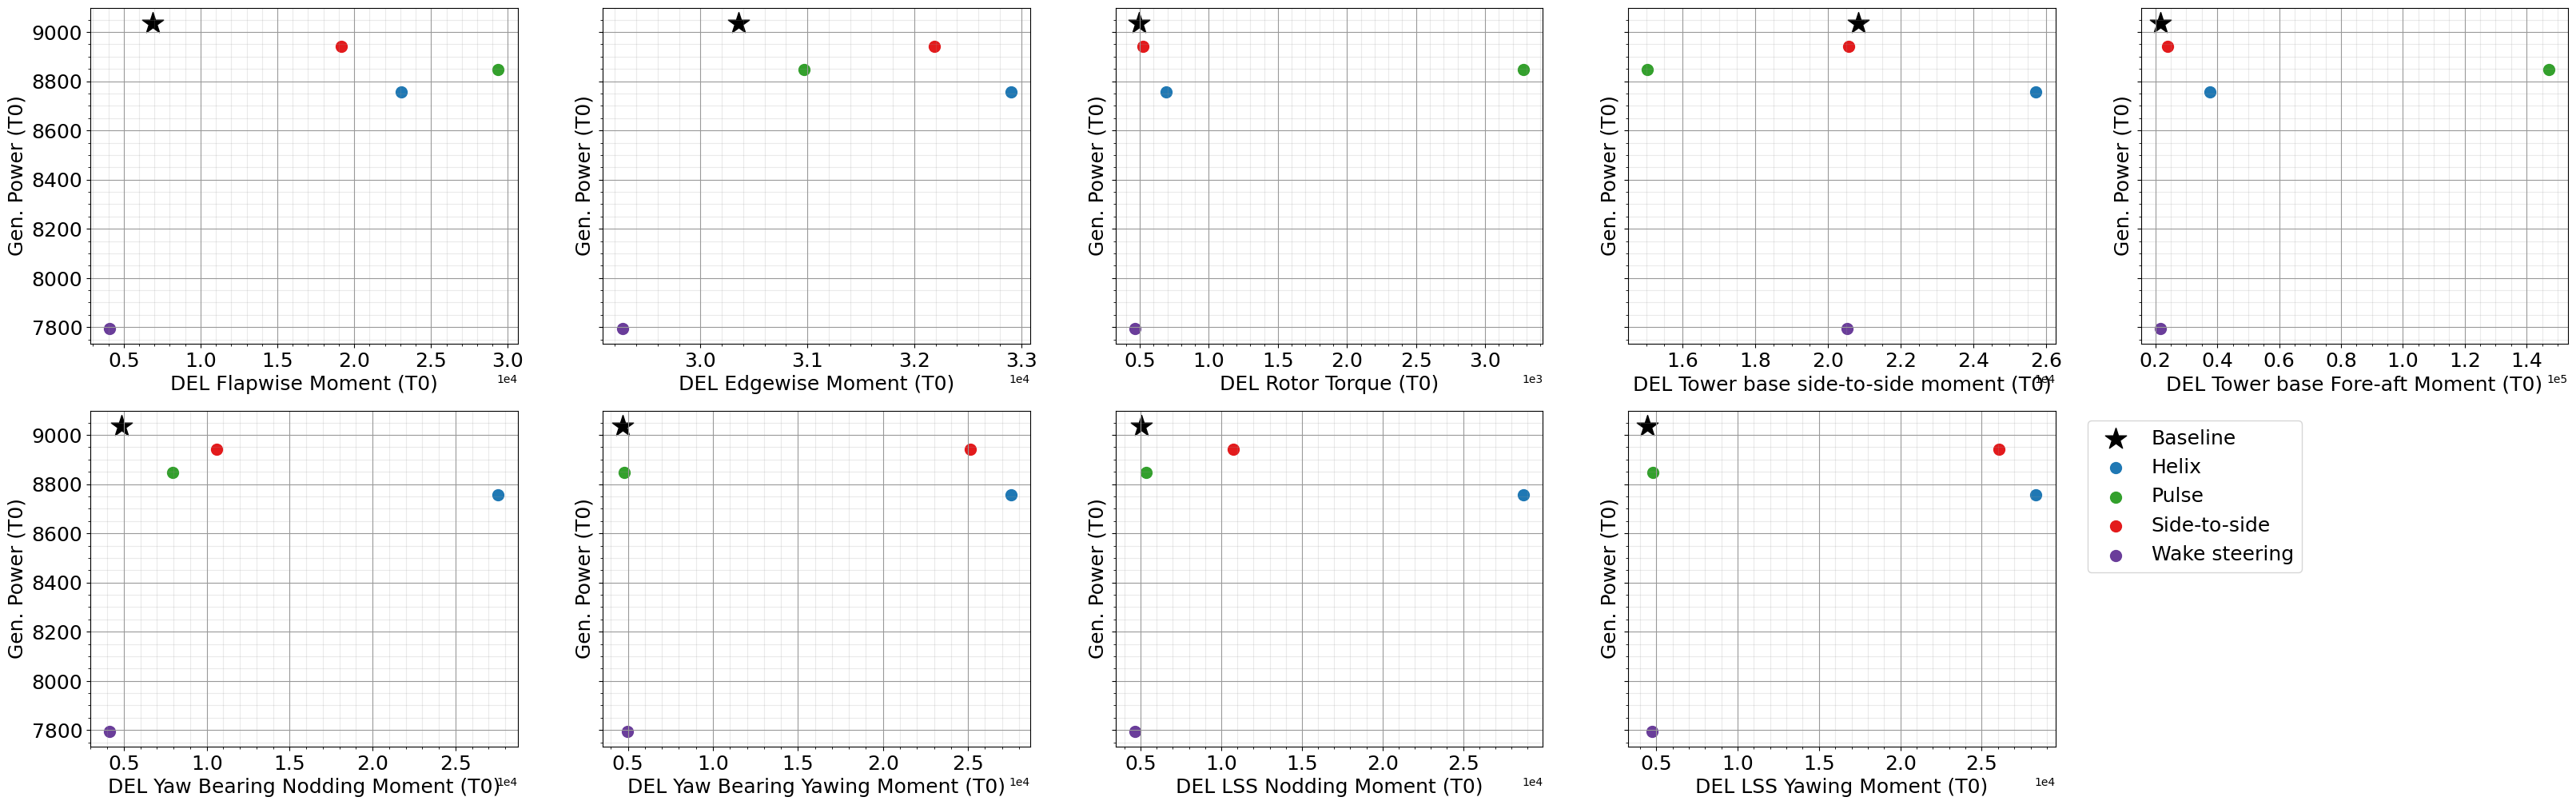

In [9]:
#plot mean data
#colors = ['k','tab:blue','tab:purple','tab:red']
colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
colors = ['k','#1f78b4','#33a02c','#e31a1c','#6a3d9a']
fig, ax1 = plt.subplots(2,5,figsize=(40,12),sharex=False,sharey=True)
ax1=ax1.flatten()
ax_counter = 0
turbine = 'T0'

for quantity in vars[4:]:
    counter = 0 
    for caseiter, case in enumerate(case_names):
        #if "WS" not in case:
        if 'baseline' in case:
            marker = '*'
        else:
            marker = '.'
        GenPwrT0 = float(caseMeans[case]['T0']['GenPwr'][0])
        GenPwrT1 = float(caseMeans[case]['T1']['GenPwr'][0])
        GenPwrT = float(caseMeans[case][turbine]['GenPwr'][0])
        GenPwrT0pT1 = GenPwrT0 + GenPwrT1
        ax1[ax_counter].scatter(caseDELs[case][turbine][quantity],GenPwrT,label=legendtxt[caseiter],c=colors[counter],marker=marker,s=400)
        counter += 1

    fsize = 18
    #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
    ax1[ax_counter].set_ylabel(f"Gen. Power ({turbine})",fontsize=fsize)
    ax1[ax_counter].set_xlabel("DEL " + vars_and_labels[quantity][0] + " ("+turbine+")",fontsize=fsize)
    ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
    ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax1[ax_counter].minorticks_on()
    ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
    ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
    ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

    #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
    #fig.tight_layout()
    ax_counter += 1

ax1[-1].axis('off')
ax1[-2].legend(loc='upper right',bbox_to_anchor=(1.6,1),fontsize=fsize)

# fig.savefig('power_v_del_abs_compSNL_T1.png',dpi=200)

In [ ]:
#plot mean data
#colors = ['k','tab:blue','tab:purple','tab:red']
colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
fig, ax1 = plt.subplots(2,5,figsize=(40,12),sharex=False,sharey=True)
ax1=ax1.flatten()
ax_counter = 0

for quantity in vars[4:]:
    counter = 0 
    for case in case_names:
        #if "WS" not in case:
        if 'Baseline' in case:
            marker = '*'
        else:
            marker = '.'
        pwrT1b = float(caseMeans['Baseline']['GenPwr6D'])
        pwrT1  = float((caseMeans[case]['GenPwr6D']))
        fig.suptitle("Combined Relative Power and DEL at X/D=6",fontsize=24)
        pwrT0  = float(caseMeans[case]['GenPwr'][0])
        pwrT0b = float(caseMeansRel[case]['GenPwr'][0])
        GenPwrT0pT1 = ((pwrT0 + pwrT1) - (pwrT0b + pwrT1b))/(pwrT0b + pwrT1b)
        ax1[ax_counter].scatter(caseDELsRel[case][quantity],GenPwrT0pT1,label=case,c=colors[counter],marker=marker,s=400)
        counter += 1

    fsize = 18
    #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
    ax1[ax_counter].set_ylabel("Gen. Power (T0 + T1)\nRelative to Baseline",fontsize=fsize)
    ax1[ax_counter].set_xlabel("DEL " + vars_and_labels[quantity][0] + " (T0)\nRelative to Baseline",fontsize=fsize)
    ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
    ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax1[ax_counter].minorticks_on()
    ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
    ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
    ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

    #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
    #fig.tight_layout()
    ax_counter += 1

ax1[-1].axis('off')
ax1[-2].legend(loc='upper right',bbox_to_anchor=(2,1),fontsize=fsize)

## Loads NREL-style

In [10]:
## HELPER FUNCTIONS

def compute_load_rose(openfastData, nSectors=18, channel_pairs=None, channel_out=None):

    if channel_pairs is None:
        channel_pairs = [['RootMxb1', 'RootMyb1'],
                         ['TwrBsMxt','TwrBsMyt'],
                         ['YawBrMyp','YawBrMzp'],
                         ['LSSTipMys','LSSTipMzs']]
    if channel_out is None:
        channel_out = ['RootMb1','TwrBsMt','YawBrMp','LSSTipMs']
        
    load_data = {}
    for case in openfastData.keys():
        load_data[case] = {}
        for ws in openfastData[case].keys():
            load_data[case][ws] = {}
            for turb in openfastData[case][ws]:
                load_data[case][ws][turb] = {}

                if nSectors%2 != 0:
                    print(f'WARNING: it is recommended to set an even number of sectors')

                # Create the sector bins
                theta_bin = np.linspace(0,np.pi, nSectors+1)

                # Bin the loads for each pair
                for p, curr_pair in enumerate(channel_pairs):
                    print(f'Processing pair {curr_pair[0]}, {curr_pair[1]}.')

                    load_0deg = openfastData[case][ws][turb][curr_pair[0]]
                    load_90deg = openfastData[case][ws][turb][curr_pair[1]]
                    load_rose = []
                    for i, theta in enumerate(theta_bin[:-1]):
                        curr_theta = (theta_bin[i] + theta_bin[i+1])/2
                        curr_load = load_0deg*np.cos(curr_theta) + load_90deg*np.sin(curr_theta)
                        load_rose = np.append(load_rose, curr_load, axis=0)

                    load_data[case][ws][turb][channel_out[p]] = np.reshape(load_rose, [len(curr_load), nSectors], order='F')

    return load_data

def compute_del(load_data, time_data, lifetime, load2stress, slope, Sult, signals = None, t0 = 500, Sc=0.0, rainflow_bins=100, return_damage=False, goodman_correction=False):
    """
    Function from pCrunch.

    Computes damage equivalent load of input `ts`.

    Parameters
    ----------
    ts : np.array
        Time series to calculate DEL for.
    elapsed : int | float
        Elapsed time of the time series.
    lifetime : int | float
        Design lifetime of the component / material in years
    load2stress : float (optional)
        Linear scaling coefficient to convert an applied load to stress such that S = load2stress * L
    slope : int | float
        Slope of the fatigue curve.
    Sult : float (optional)
        Ultimate stress for use in Goodman equivalent stress calculation
    Sc : float (optional)
        Stress-axis intercept of log-log S-N Wohler curve. Taken as ultimate stress unless specified
    rainflow_bins : int
        Number of bins used in rainflow analysis.
        Default: 100
    return_damage: boolean
        Whether to compute both DEL and damage
        Default: False
    goodman_correction: boolean
        Whether to apply Goodman mean correction to loads and stress
        Default: False

    """

    DEL_all = {}
    DEL_max = {}
    
    for case in load_data.keys():
        print(f"Calculating DELs for case {case}")
        DEL_all[case] = {}
        DEL_max[case] = {}
        for ws in load_data[case].keys():
            DEL_all[case][ws] = {}
            DEL_max[case][ws] = {}
            for turb in load_data[case][ws]:
                if signals is None:
                    signals = load_data[case][ws][turb].keys()
                DEL_all[case][ws][turb] = []
                DEL_max[case][ws][turb] = []
        
                i0 = np.where(time_data[case][ws][turb]['Time'] >= t0)[0][0]
                elapsed = time_data[case][ws][turb]['Time'].iloc[t0]-time_data[case][ws][turb]['Time'].iloc[0]

                for n, signal in enumerate(signals):

                    ts = load_data[case][ws][turb][signal]

                    Scin = Sc if Sc > 0.0 else Sult[n]

                    try:
                        kmax = ts.shape[1]
                    except:
                        kmax = 1
                    for k in range(kmax):
                        try:
                            F, Fmean = fatpack.find_rainflow_ranges(ts[i0:,k], return_means=True)
                        except:
                            F, Fmean = fatpack.find_rainflow_ranges(ts[i0:], return_means=True)
                        fatpack_rainflow_successful = 1
                    #     except:
                    #         print(f'Fatpack call for find_rainflow_ranges did not work. Setting F=Fmean=0')
                    #         fatpack_rainflow_successful = 0
                    #         F = Fmean = np.zeros(1)

                        if goodman_correction and np.abs(load2stress[n]) > 0.0:
                            F = fatpack.find_goodman_equivalent_stress(F, Fmean, Sult[n]/np.abs(load2stress[n]))

                        Nrf, Frf = fatpack.find_range_count(F, rainflow_bins)
                        DELs = Frf ** slope[n] * Nrf / elapsed
                        DEL = DELs.sum() ** (1.0 / slope[n])
                        # With fatpack do:
                        #curve = fatpack.LinearEnduranceCurve(1.)
                        #curve.m = slope
                        #curve.Nc = elapsed
                        #DEL = curve.find_miner_sum(np.c_[Frf, Nrf]) ** (1 / slope[n])

                        DEL_all[case][ws][turb] = np.append(DEL_all[case][ws][turb], DEL)

                        D = np.nan # default return value
                        if return_damage and np.abs(load2stress[n]) > 0.0:
                            try:
                                S, Mrf = fatpack.find_rainflow_ranges(ts*load2stress[n], return_means=True)
                            except:
                                S = Mrf = np.zeros(1)
                            if goodman_correction:
                                S = fatpack.find_goodman_equivalent_stress(S, Mrf, Sult[n])
                            Nrf, Srf = fatpack.find_range_count(S, rainflow_bins)
                            curve = fatpack.LinearEnduranceCurve(Scin)
                            curve.m = slope[n]
                            curve.Nc = 1
                            D = curve.find_miner_sum(np.c_[Srf, Nrf])
                            if lifetime[n] > 0.0:
                                D *= lifetime*365.0*24.0*60.0*60.0 / elapsed

                # Compute Palmgren/Miner damage using stress
                DEL_all[case][ws][turb] = np.reshape(DEL_all[case][ws][turb], \
                                                [kmax, len(signals)], order='F')
                DEL_max[case][ws][turb] = np.max(DEL_all[case][ws][turb], axis=0)
            
    if not return_damage:
        return DEL_all, DEL_max
                    
    return DEL, D, fatpack_rainflow_successful

In [11]:
dels = []
load_data = compute_load_rose(openfastData)

Processing pair RootMxb1, RootMyb1.
Processing pair TwrBsMxt, TwrBsMyt.
Processing pair YawBrMyp, YawBrMzp.
Processing pair LSSTipMys, LSSTipMzs.
Processing pair RootMxb1, RootMyb1.
Processing pair TwrBsMxt, TwrBsMyt.
Processing pair YawBrMyp, YawBrMzp.
Processing pair LSSTipMys, LSSTipMzs.
Processing pair RootMxb1, RootMyb1.
Processing pair TwrBsMxt, TwrBsMyt.
Processing pair YawBrMyp, YawBrMzp.
Processing pair LSSTipMys, LSSTipMzs.
Processing pair RootMxb1, RootMyb1.
Processing pair TwrBsMxt, TwrBsMyt.
Processing pair YawBrMyp, YawBrMzp.
Processing pair LSSTipMys, LSSTipMzs.
Processing pair RootMxb1, RootMyb1.
Processing pair TwrBsMxt, TwrBsMyt.
Processing pair YawBrMyp, YawBrMzp.
Processing pair LSSTipMys, LSSTipMzs.
Processing pair RootMxb1, RootMyb1.
Processing pair TwrBsMxt, TwrBsMyt.
Processing pair YawBrMyp, YawBrMzp.
Processing pair LSSTipMys, LSSTipMzs.
Processing pair RootMxb1, RootMyb1.
Processing pair TwrBsMxt, TwrBsMyt.
Processing pair YawBrMyp, YawBrMzp.
Processing pair 

In [12]:
lifetime = [25, 25, 25, 25]
load2stress = [1, 1, 1, 1]
slope = [10, 4, 4, 4]
Sult = [1.047e9, 450e6, 133e6, 814e6]

DELs_rose, DELs_max = compute_del(load_data, openfastData, lifetime, load2stress, slope, Sult, goodman_correction=True)

Calculating DELs for case baseline_2T
Calculating DELs for case ccwhelix_St03_A40_2T
Calculating DELs for case dic_St03_A40_2T
Calculating DELs for case sideside_St03_A40_2T
Calculating DELs for case wakesteering_20deg_2T


baseline_2T, RootMb1: 104984.13017419286
baseline_2T, power: 12037.465250000001
ccwhelix_St03_A40_2T, RootMb1: 117717.94414358363
ccwhelix_St03_A40_2T, power: 12566.944924088813
dic_St03_A40_2T, RootMb1: 124043.38209086921
dic_St03_A40_2T, power: 13044.085919760819
sideside_St03_A40_2T, RootMb1: 115273.79399342311
sideside_St03_A40_2T, power: 12531.1077935986
wakesteering_20deg_2T, RootMb1: 102501.32218564182
wakesteering_20deg_2T, power: 12953.163178571427
baseline_2T, TwrBsMt: 670675.887613725
baseline_2T, power: 12037.465250000001
ccwhelix_St03_A40_2T, TwrBsMt: 607276.6894923449
ccwhelix_St03_A40_2T, power: 12566.944924088813
dic_St03_A40_2T, TwrBsMt: 879424.6584882955
dic_St03_A40_2T, power: 13044.085919760819
sideside_St03_A40_2T, TwrBsMt: 865902.8100500033
sideside_St03_A40_2T, power: 12531.1077935986
wakesteering_20deg_2T, TwrBsMt: 341050.22758386354
wakesteering_20deg_2T, power: 12953.163178571427
baseline_2T, YawBrMp: 64703.702186042094
baseline_2T, power: 12037.465250000001
c

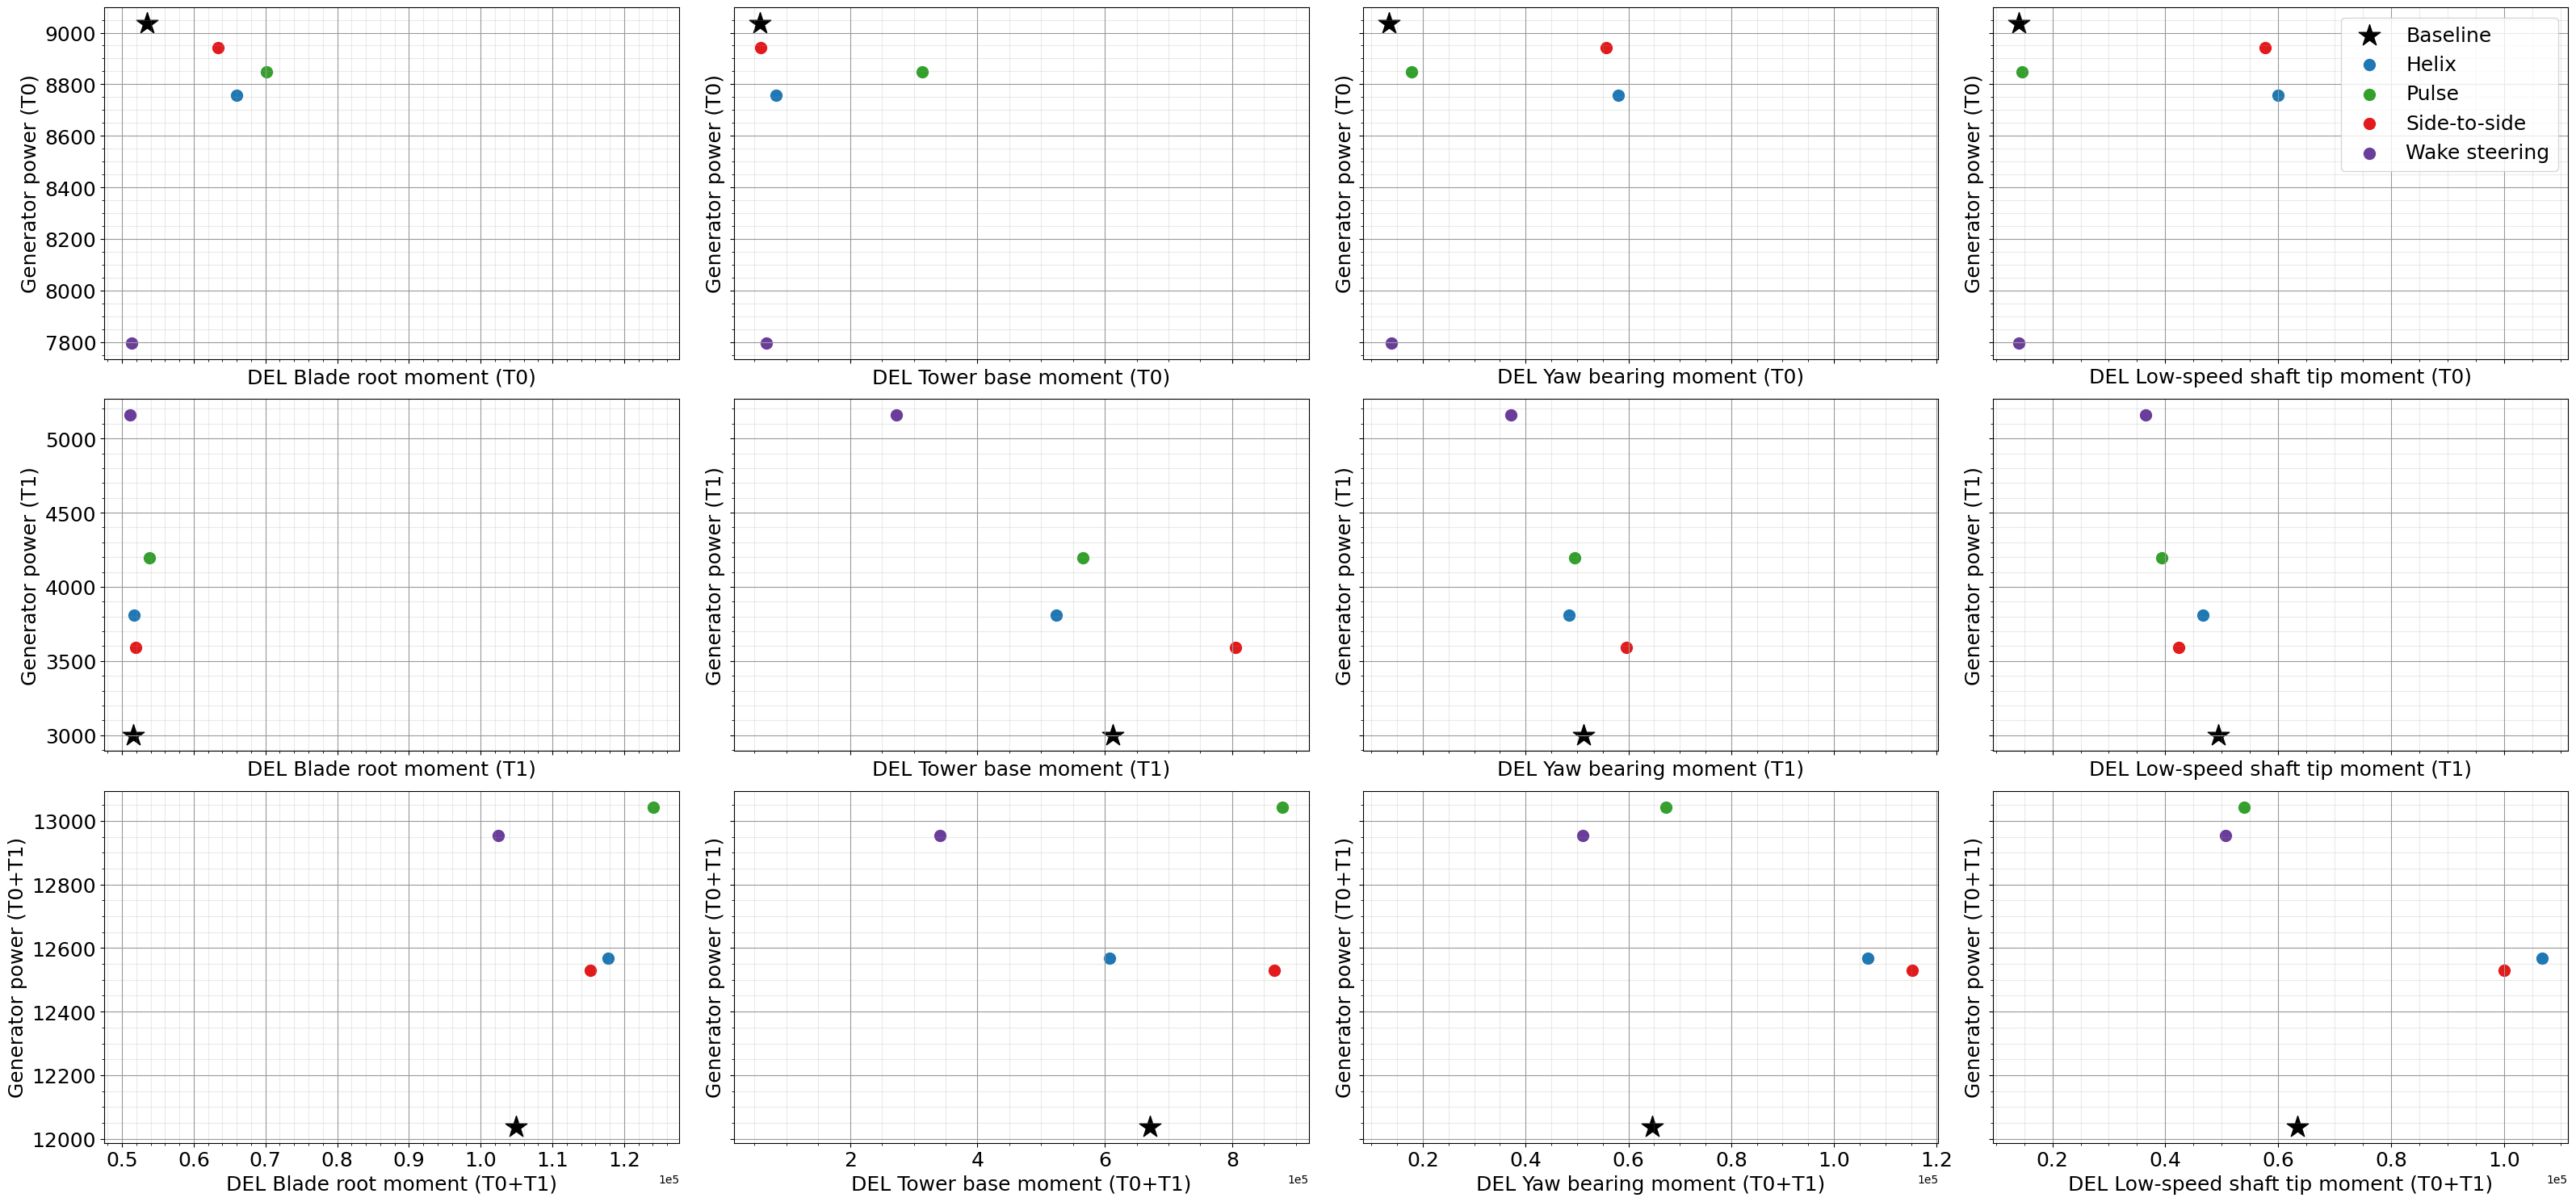

In [28]:
#plot mean data
#colors = ['k','tab:blue','tab:purple','tab:red']
colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
colors = ['k','#1f78b4','#33a02c','#e31a1c','#6a3d9a']
fig, ax1 = plt.subplots(3,4,figsize=(32,15),sharex='col',sharey='row', tight_layout=True)
ax1=ax1.flatten()
ax_counter = 0
baseline_power = caseMeans['baseline_2T']['T0']['GenPwr'][0]+caseMeans['baseline_2T']['T1']['GenPwr'][0]
xlabels = ['Blade root moment','Tower base moment','Yaw bearing moment','Low-speed shaft tip moment']
# for turbine in turbines[0]:
ws = '9.05'
del_labels = ['RootMb1','TwrBsMt','YawBrMp','LSSTipMs']
for turb in ['T0','T1', 'T0+T1']:
    for quantity in range(4): 
    
        counter = 0
        for nc, case in enumerate(case_names):
            #if "WS" not in case:
            if 'baseline' in case:
                marker = '*'
            else:
                marker = '.'
            total_power = (caseMeans[case]['T0']['GenPwr'][0]+caseMeans[case]['T1']['GenPwr'][0])
            total_del = (DELs_max[case][ws]['T0'][quantity]+DELs_max[case][ws]['T1'][quantity])
#             baseDEL = DELs_max['baseline_2T'][ws][turb][quantity]
            if turb == 'T0+T1':
                ax1[ax_counter].scatter(total_del,total_power,label=legendtxt[nc],c=colors[counter],marker=marker,s=400)
                print(f"{case}, {del_labels[quantity]}: {total_del}")
                print(f"{case}, power: {total_power}")
            else:
                ax1[ax_counter].scatter(DELs_max[case][ws][turb][quantity],caseMeans[case][turb]['GenPwr'],label=legendtxt[nc],c=colors[counter],marker=marker,s=400)
            counter += 1

        fsize = 18
        #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
        ax1[ax_counter].set_ylabel(f"Generator power ({turb})",fontsize=fsize)
        ax1[ax_counter].set_xlabel("DEL " + xlabels[quantity] + " ("+turb+")",fontsize=fsize)
        ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
        ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax1[ax_counter].minorticks_on()
        ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
        ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
        ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

        #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
        #fig.tight_layout()
        ax_counter += 1

# ax1[-1].axis('off')
ax1[3].legend(loc='upper right',bbox_to_anchor=(1,1),fontsize=fsize)

fig.savefig('power_v_del_nrel.png',dpi=300)

DEL change for baseline_2T: 0.0
Power change for baseline_2T: 0.0
DEL change for ccwhelix_St03_A40_2T: 0.12129275108783052
Power change for ccwhelix_St03_A40_2T: 0.043985977370843275
DEL change for dic_St03_A40_2T: 0.18154412371710527
Power change for dic_St03_A40_2T: 0.08362397305868173
DEL change for sideside_St03_A40_2T: 0.09801161187083539
Power change for sideside_St03_A40_2T: 0.04100884474815812
DEL change for wakesteering_20deg_2T: -0.02364936476047844
Power change for wakesteering_20deg_2T: 0.07607066018914788
DEL change for baseline_2T: 0.0
Power change for baseline_2T: 0.0
DEL change for ccwhelix_St03_A40_2T: -0.0945303078465449
Power change for ccwhelix_St03_A40_2T: 0.043985977370843275
DEL change for dic_St03_A40_2T: 0.31125134320439307
Power change for dic_St03_A40_2T: 0.08362397305868173
DEL change for sideside_St03_A40_2T: 0.29108981855736404
Power change for sideside_St03_A40_2T: 0.04100884474815812
DEL change for wakesteering_20deg_2T: -0.49148279536733397
Power change

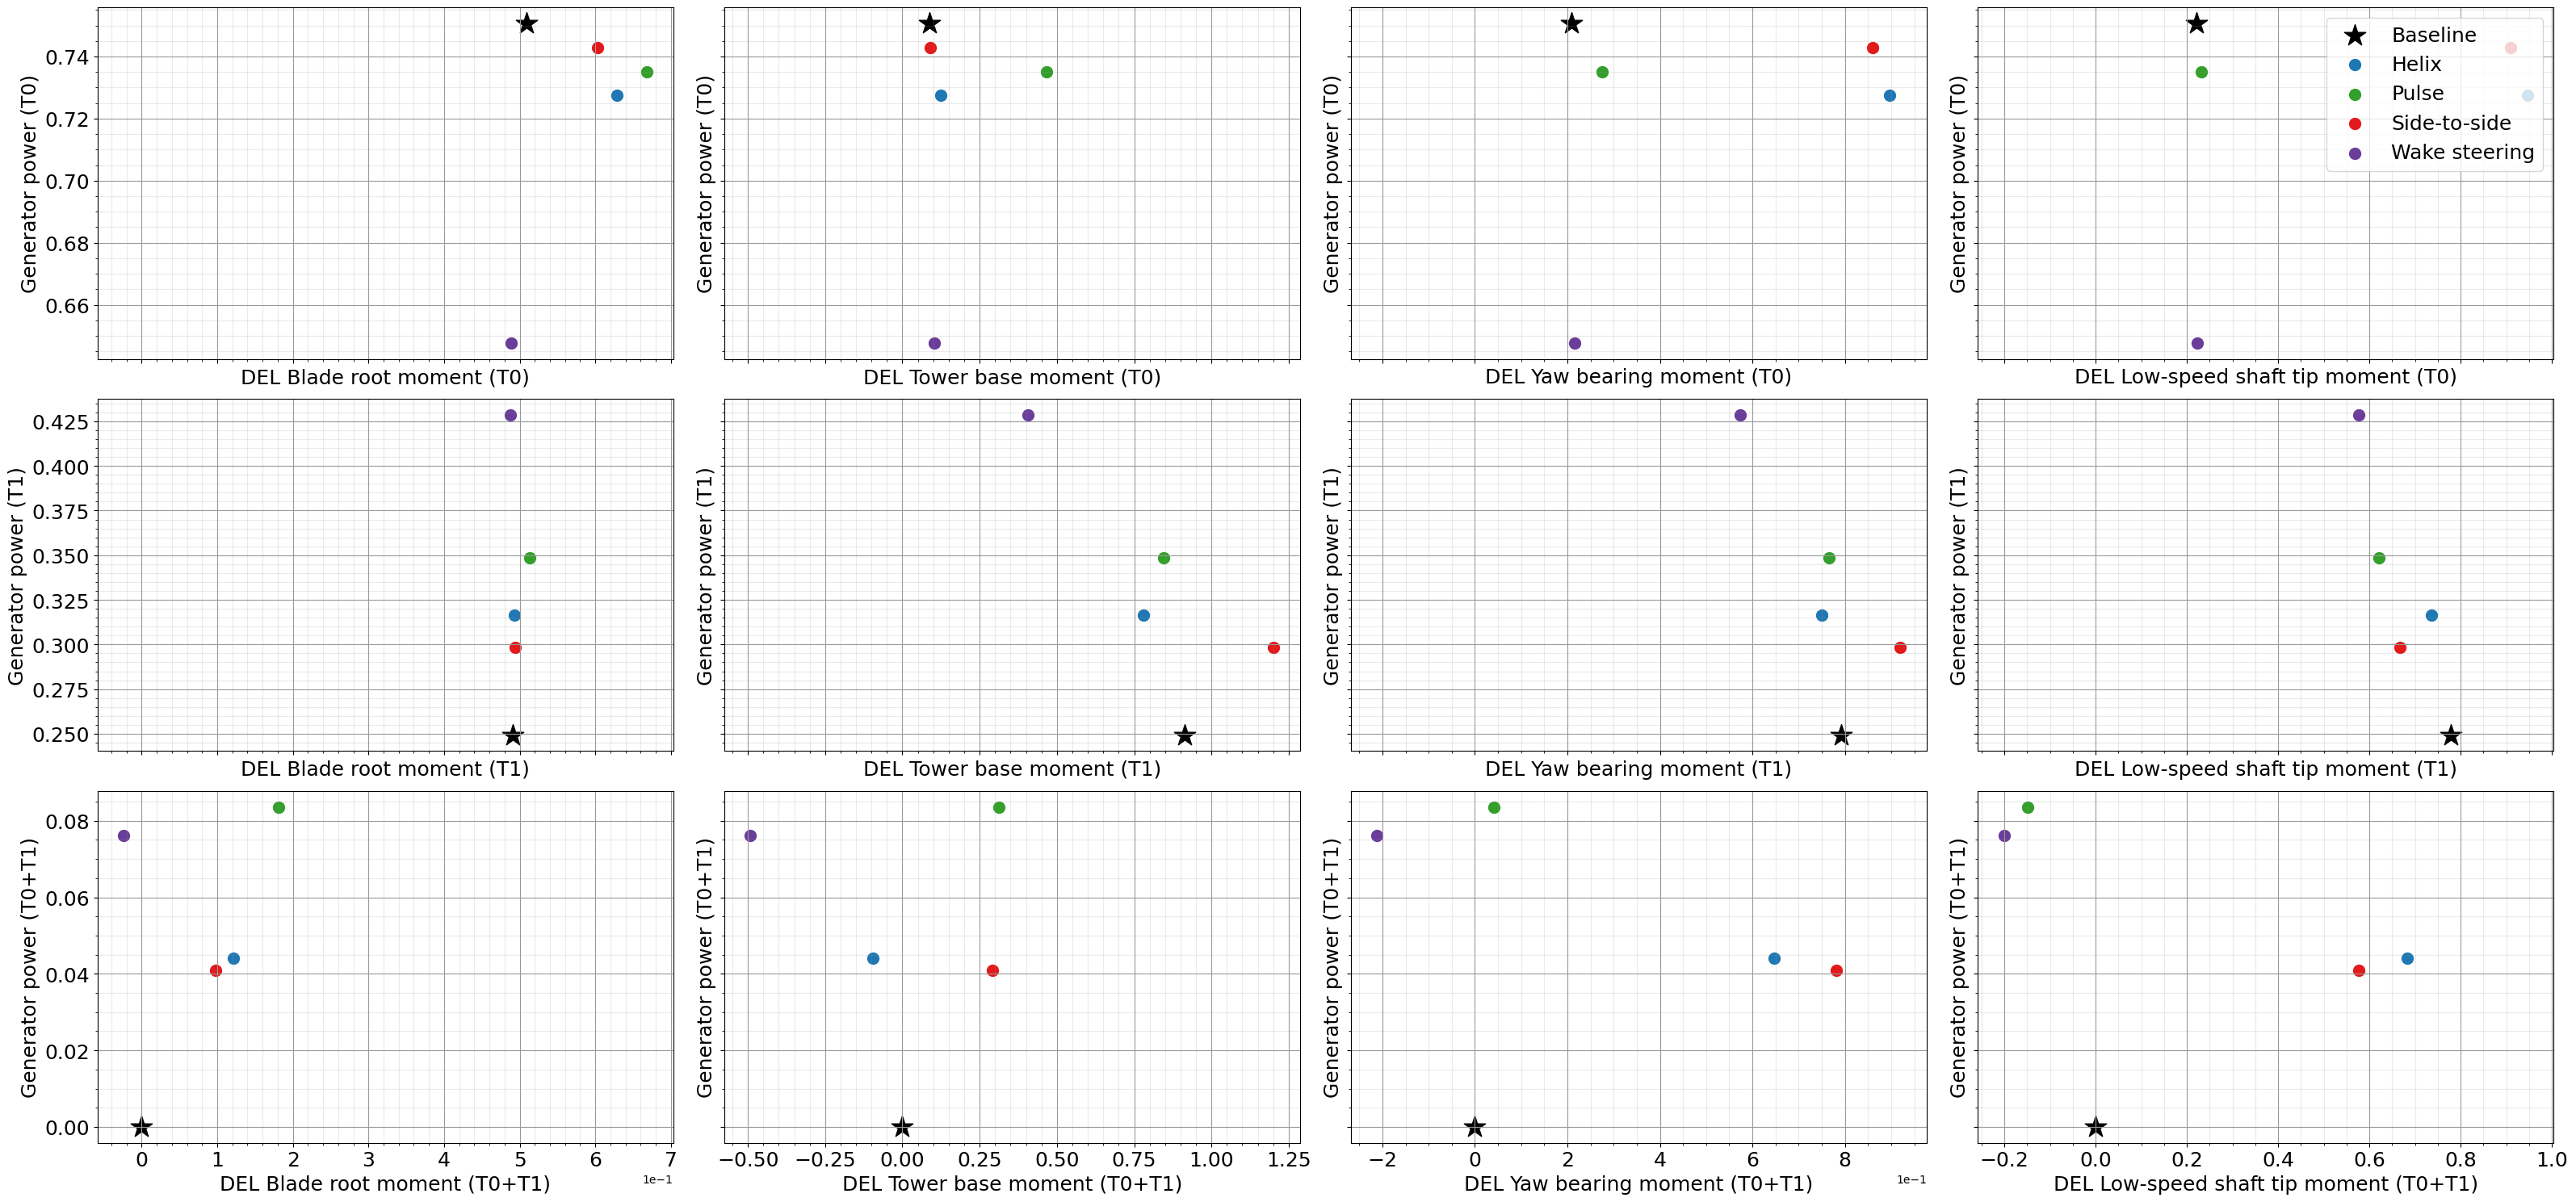

In [25]:
#plot mean data
#colors = ['k','tab:blue','tab:purple','tab:red']
colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
colors = ['k','#1f78b4','#33a02c','#e31a1c','#6a3d9a']
fig, ax1 = plt.subplots(3,4,figsize=(32,15),sharex='col',sharey='row', tight_layout=True)
ax1=ax1.flatten()
ax_counter = 0
baseline_power = caseMeans['baseline_2T']['T0']['GenPwr'][0]+caseMeans['baseline_2T']['T1']['GenPwr'][0]
xlabels = ['Blade root moment','Tower base moment','Yaw bearing moment','Low-speed shaft tip moment']
# for turbine in turbines[0]:
ws = '9.05'
del_labels = ['RootMb1','TwrBsMt','YawBrMp','LSSTipMs']
for turb in ['T0','T1', 'T0+T1']:
    for quantity in range(4): 
    
        counter = 0
        for nc, case in enumerate(case_names):
            #if "WS" not in case:
            if 'baseline' in case:
                marker = '*'
            else:
                marker = '.'
            total_power = (caseMeans[case]['T0']['GenPwr'][0]+caseMeans[case]['T1']['GenPwr'][0])
            total_del = (DELs_max[case][ws]['T0'][quantity]+DELs_max[case][ws]['T1'][quantity])
            baseDEL = (DELs_max['baseline_2T'][ws]['T0'][quantity]+DELs_max['baseline_2T'][ws]['T1'][quantity])
            basePwr = caseMeans['baseline_2T']['T0']['GenPwr'][0]+caseMeans['baseline_2T']['T1']['GenPwr'][0]
            if turb == 'T0+T1':
                ax1[ax_counter].scatter((total_del-baseDEL)/baseDEL,(total_power-basePwr)/basePwr,label=legendtxt[nc],c=colors[counter],marker=marker,s=400)
                print(f'DEL change for {case}: {(total_del-baseDEL)/baseDEL}')
                print(f'Power change for {case}: {(total_power-basePwr)/basePwr}')
            else:
                ax1[ax_counter].scatter(DELs_max[case][ws][turb][quantity]/baseDEL,caseMeans[case][turb]['GenPwr']/basePwr,label=legendtxt[nc],c=colors[counter],marker=marker,s=400)
            counter += 1

        fsize = 18
        #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
        ax1[ax_counter].set_ylabel(f"Generator power ({turb})",fontsize=fsize)
        ax1[ax_counter].set_xlabel("DEL " + xlabels[quantity] + " ("+turb+")",fontsize=fsize)
        ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
        ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax1[ax_counter].minorticks_on()
        ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
        ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
        ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

        #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
        #fig.tight_layout()
        ax_counter += 1

# ax1[-1].axis('off')
ax1[3].legend(loc='upper right',bbox_to_anchor=(1,1),fontsize=fsize)

fig.savefig('power_v_del_rel_nrel.png',dpi=300)

In [15]:
caseMeans

{'baseline_2T': {'T0': {'Time': [],
   'RotSpeed': [],
   'GenPwr': [9036.677785714286],
   'BldPitch1': [0.0],
   'RootMyb1': [48111.628],
   'RootMxb1': [4445.323788300713],
   'RotTorq': [14186.1115],
   'TwrBsMxt': [17353.06514214286],
   'TwrBsMyt': [179592.45785714284],
   'YawBrMyp': [-52648.931214285716],
   'YawBrMzp': [1119.418814350357],
   'LSSTipMys': [2129.278714854286],
   'LSSTipMzs': [2315.5384655817143]},
  'T1': {'Time': [],
   'RotSpeed': [],
   'GenPwr': [3000.787464285714],
   'BldPitch1': [1.178969835714286],
   'RootMyb1': [25508.662714285714],
   'RootMxb1': [1398.8165086237427],
   'RotTorq': [5987.150507142857],
   'TwrBsMxt': [8229.408446733574],
   'TwrBsMyt': [49378.176589892864],
   'YawBrMyp': [-58256.684571428574],
   'YawBrMzp': [-777.9580241357145],
   'LSSTipMys': [615.8930648110713],
   'LSSTipMzs': [-373.2584880467143]}},
 'ccwhelix_St03_A40_2T': {'T0': {'Time': [],
   'RotSpeed': [],
   'GenPwr': [8757.395791389328],
   'BldPitch1': [3.91119475392

In [6]:
caseMeans

{'baseline_2T': {'T0': {'Time': [],
   'RotSpeed': [],
   'GenPwr': [9036.677785714286],
   'BldPitch1': [0.0],
   'RootMyb1': [48111.628],
   'RootMxb1': [4445.323788300713],
   'RotTorq': [14186.1115],
   'TwrBsMxt': [17353.06514214286],
   'TwrBsMyt': [179592.45785714284],
   'YawBrMyp': [-52648.931214285716],
   'YawBrMzp': [1119.418814350357],
   'LSSTipMys': [2129.278714854286],
   'LSSTipMzs': [2315.5384655817143]},
  'T1': {'Time': [],
   'RotSpeed': [],
   'GenPwr': [3000.787464285714],
   'BldPitch1': [1.178969835714286],
   'RootMyb1': [25508.662714285714],
   'RootMxb1': [1398.8165086237427],
   'RotTorq': [5987.150507142857],
   'TwrBsMxt': [8229.408446733574],
   'TwrBsMyt': [49378.176589892864],
   'YawBrMyp': [-58256.684571428574],
   'YawBrMzp': [-777.9580241357145],
   'LSSTipMys': [615.8930648110713],
   'LSSTipMzs': [-373.2584880467143]}},
 'ccwhelix_St03_A40_2T': {'T0': {'Time': [],
   'RotSpeed': [],
   'GenPwr': [8757.395791389328],
   'BldPitch1': [3.91119475392